In [1]:
# # Run this and then restart the kernel at the start of each session to install
# # 'teotil3' in development mode
# !pip install -e /home/jovyan/projects/teotil3/

In [2]:
import os

import geopandas as gpd
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import numpy as np
import pandas as pd
import teotil3 as teo

plt.style.use("ggplot")

In [3]:
# Connect to JupyterHub's PostGIS database
eng = nivapy.da.connect_postgis()

Connection successful.


# Avlastningsbehov using TEOTIL: Hålandsvatnet example

## How can we achieve Good Ecological Status (GES) for TOTP at Hålandsvatnet in Rogaland?

This notebook illustrates some steady-state calculations using a mixture of TEOTIL2 and TEOTIL3 input datasets. **It is not intended to provide a definitive answer to the question above** - it is just an example showing how TEOTIL can be used to quickly produce back-of-the-envelope estimates for load reduction targets. 

When finished, **TEOTIL3 should produce better results**. In this notebook, TEOTIL3 output is used where possible, but supplemented with TEOTIL2 data for components that are not yet finished in TEOTIL3. Note, however, that TEOTIL2 and TEOTIL3 are both "high level" tools, so they should not be used as substitutes for local knowledge or to replace more detailed, site-specific assessments - especially for small catchments like Hålandsvatnet.

## 1. Reference data from NIBIO

In 2022, NIBIO produced a detailed assessment of nutrient fluxes to Hålandsvatnet: [Tilførsler og avlastningsbehov for Hålandsvatnet i Rogaland](https://www.statsforvalteren.no/contentassets/ecb81c041711449fbbe54b0ea7d1a3d6/2-2022-norce-nibio-tilforsel-og-avlastingsbehov-for-halandsvatnet-i-rogaland-m2308.pdf). This report provides the best available summary of avlastningsbehov for this catchment.

The aim of this notebook is to see what we can say about Hålandsvatnet quickly using TEOTIL and compare this to the more detailed and labour-intensive estimates provided by the NIBIO report. **The TEOTIL output is not expected to be as good as that from a site-specific case study**. However, it is hoped that the model can still provide a useful high-level overview from a management perspective.

**The focus in this example is on total P (TOTP)**.

## 2. Input data from TEOTIL3

Hålandsvatnet corresponds to regine `028.7B`. The code below gets basic catchment properties for this regine from TEOTIL3.

In [4]:
# User input

# Year for nutrient inputs
year = 2021

# Year for admin. boundaries
admin_year = 2022

# Regine ID for Hålandsvatnet
reg_id = "028.7B"

100.00 % of regines assigned.


<Axes: >

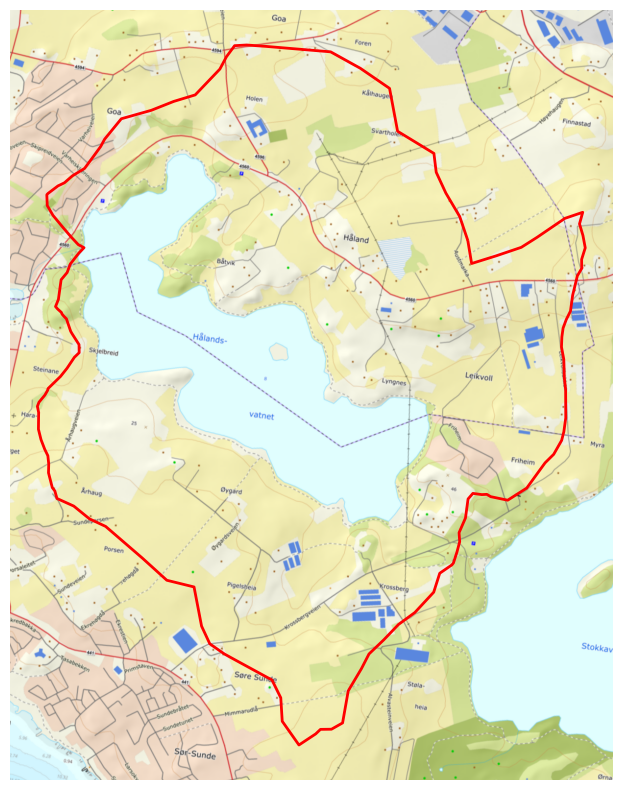

In [5]:
# Get regine data
reg_gdf = teo.io.get_regine_geodataframe(eng, admin_year)

# Determine hydrological connectivity
reg_gdf = teo.io.assign_regine_hierarchy(
    reg_gdf,
    regine_col="regine",
    regine_down_col="regine_down",
    order_coastal=False,
    nan_to_vass=True,
    land_to_vass=True,
    add_offshore=True,
)

# Build network graph from adjacency matrix
g = teo.model.build_graph(reg_gdf, id_col="regine", next_down_col="regine_down")

# Plot the specified regine and all contributing regines upstream
gdf, ax = teo.vis.plot_catchment(
    g, reg_id, reg_gdf, id_col="regine", include_connected=True, direct="up"
)
ax

In [6]:
# Print summary data for regine of interest
reg_df = reg_gdf.drop("geometry", axis="columns").query("regine == @reg_id")
reg_df.set_index("regine", inplace=True)
display(reg_df.T)

# Print lake properties
lake_df = pd.read_csv("../../data/lake_residence_times_10m_dem.csv").query(
    "regine == @reg_id"
)
lake_df.set_index("regine", inplace=True)
display(lake_df.T)

# Print "local" inputs of TOTP for regine of interest
in_csv = f"/home/jovyan/shared/common/teotil3/annual_input_data/teotil3_input_data_nve2023_{year}.csv"
teo3_df = pd.read_csv(in_csv)
teo3_df = teo3_df.query("regine == @reg_id")
teo3_df.set_index("regine", inplace=True)
cols = [col for col in teo3_df.columns if "totp" in col]
teo3_df = teo3_df[cols]
display(teo3_df.T)

regine,028.7B
regine_down,028.7A
vassom,028
a_cat_poly_km2,5.982502
ospar_region,North Sea
komnr,1127
fylnr,11
a_agri_km2,3.664547
a_glacier_km2,0.0
a_lake_km2,1.240235
a_other_km2,0.0


regine,028.7B
vatnLnr,1554.000000
area_km2,1.202400
catch_area_km2,6.020000
vol_Mm3,10.084000
res_time_yr,1.318000
accum_upstr_area_km2,5.982502
local_a_cat_land_km2,5.982502
accum_q_m3/s,0.187110
local_q_cat_m3/s,0.187110
a_upstr_reg_km2,0.000000


regine,028.7B
trans_totp,0.46554
wood_totp_kg,0.90000
upland_totp_kg,0.20000
urban_totp_kg,77.20000
spredt_totp_kg,135.90000
aquaculture_totp_kg,0.00000
industry_totp_kg,0.00000
large-wastewater_totp_kg,0.00000


Based on the above output from TEOTIL3, we see that:

 * Long-term mean runoff (1990 - 2021) is 987 mm/year, corresponding to a mean discharge of 0.19 m3/s
 
 * The area of the lake is 1.2 km2 and the area of the whole catchment is 6 km2
 
 * Catchment land cover is predominantly agricultural (3.7 km2), followed lake (1.2 km2), urban (0.6 km2) and woodland (0.4 km2)
 
 * Lake volume is around 10.1 Mm3, the residence time is about 1.3 years, and the hydraulic load is 6.4 m/year
 
 * The transmission factor for TOTP is about 0.47
 
 * In 2021, the main estimated inputs of TOTP were 136 kg from spredt and 77 kg from urban areas. **Note that agriculture is not yet included in TEOTIL3 (see below)**. The flux from urban areas may also be too high - see the issue [here](https://github.com/NIVANorge/teotil3/issues/13) for details.

## 3. Input data from TEOTIL2

TEOTIL3 does not yet include agricultural inputs (work in progress). Instead, we can use the old agricultural estimates from TEOTIL2.

In [7]:
url = f"https://raw.githubusercontent.com/NIVANorge/teotil2/main/data/norway_annual_input_data/input_data_{year}.csv"
teo2_df = pd.read_csv(url)
teo2_df = teo2_df.query("regine == @reg_id")
teo2_df.set_index("regine", inplace=True)
cols = [col for col in teo2_df.columns if "tot-p" in col]
teo2_df = teo2_df[cols]
teo2_df.T

regine,028.7B
trans_tot-p,0.470000
aqu_tot-p_tonnes,0.000000
ind_tot-p_tonnes,0.000000
ren_tot-p_tonnes,0.000000
spr_tot-p_tonnes,0.189349
agri_pt_tot-p_tonnes,0.040523
all_point_tot-p_tonnes,0.229872
urban_tot-p_tonnes,0.000000
agri_diff_tot-p_tonnes,0.789172
nat_diff_tot-p_tonnes,0.099430


In addition to the TEOTIL3 values above, TEOTIL2 estimates:

 * 40 kg of TOTP from point agricultural sources
 * 789 kg of TOTP from diffuse agricultural sources
 
## 4. Comparison to NIBIO report

The table below compares the TEOTIL values to those in the NIBIO report.


|             **Parameter**             | **TEOTIL** | **NIBIO** |
|:-------------------------------------:|:----------:|:---------:|
|          Catchment area (km2)         |        6.0 |       6.2 |
|            Lake area (km2)            |        1.2 |       1.2 |
|        Agricultural area (km2)        |        3.7 |       3.4 |
|            Urban area (km2)           |        0.6 |       0.5 |
|          Woodland area (km2)          |        0.4 |       0.6 |
|          Mean runoff (mm/yr)          |        987 |       980 |
|           Lake volume (Mm3)           |       10.1 |      11.3 |
|         Residence time (years)        |        1.3 |       1.9 |
|         Transmission TOTP (-)         |       0.47 |      0.35 |
|            Spredt TOTP (kg)           |        136 |        33 |
|            Urban TOTP (kg)            |         78 |         5 |
|  Point-source agricultural TOTP (kg)  |        40* |         0 |
| Diffuse-source agricultural TOTP (kg) |       789* |       631 |

In general, TEOTIL makes it fairly easy to extract key information for a wide range of Norwegian waterbodies. The results overall are fairly comparable to those in the NIBIO report. However, note the following:

 * TEOTIL seems to overestimate the "spredt" component. This is likely due to the coarse way spredt data from SSB are allocated to agricultural areas. This should be improved once we switch to the more detailed agricultural divisions in the new NIBIO models. However, it will always be a limitation as long as spredt data are provided aggregated to kommune level. 
 
 * TEOTIL dramatically overestimates the urban inputs compared to the NIBIO estimates. Overall, I am a little concerned about the new TEOTIL estimates based on [Åstebøl et al. (2012)](https://www.miljodirektoratet.no/sharepoint/downloaditem?id=01FM3LD2XYMQWENJOBOVEL2YIHX3PUTEYP), as they seem so much higher than everything else (see the issue [here](https://github.com/NIVANorge/teotil3/issues/13) for details). It would be interesting to know what the NIBIO estimates are based on.
 
 * The agricultural inputs for TEOTIL (marked `*` in the table) are based on TEOTIL2 (i.e. the old model). These data come from NIBIO, so differences are presumably due to the coarse spatial resolution of the agricultural data used by TEOTIL. Hopefully this will improve once the new NIBIO models are linked to TEOTIL3.
 
## 5. Load reduction targets

According to the NIBIO report, the TOTP threshold for GES for Hålandavatnet is 17 ug-P/l. Using the data from TEOTIL, we can perform a very simple water balance as follows:

 1. The typical annual outflow volume from the lake is $0.987 \times 6.10^6 = 5.9 \ Mm^3$
 
 2. Assuming the lake is well-mixed and at GES, this corresponds to a maximum permitted TOTP flux from the outflow of
 
$$\frac{17 \times 1000 \times 5.9.10^6}{1.10^9} = 101 \ kg/yr$$

 3. The transmission factor is 0.47 i.e. at steady state, flux from the outflow is 47% of the inflow flux. The maximum permitted inflow flux of TOTP for GES is therefore $214 \ kg/yr$
 
 4. Present-day fluxes of TOTP to Hålandsvatnet are about 1000 kg/yr according to TEOTIL and about 730 kg/yr according to NIBIO. (It is likely that these two estimates will become more similar once the issues highlighted in section 4 are resolved). Either way, **substantial nutrient reductions of between 500 and 800 kg of TOTP per year must be achieved for the lake to achieve GES at steady state**. It is difficult to see how this could be implemented practically for Hålandsvatnet.
 
If we take the TOTP inputs from the NIBIO report (which are assumed to be better than those from TEOTIL) and combine them with the hydrological data from the new TEOTIL model, we can plot steady-state lake concentrations as a function of percentage load reduction. The code below assumes the annual TOTP input from all sources to Hålandsvatnet is around 700 kg/year.

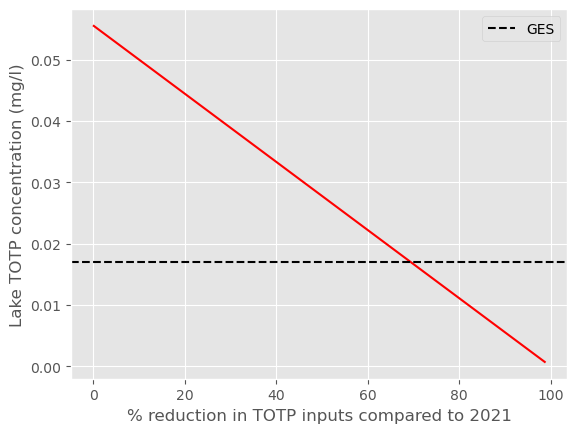

In [8]:
flux_in = 700
trans = 0.47
runoff_mm = 987
cat_area_km2 = 6
ges_mgpl = 0.017

mits = np.arange(1, flux_in, 10)
pct_red = 100 * mits / flux_in
c_list = []
for mit in mits:
    c = (trans * 1e6 * (flux_in - mit)) / (runoff_mm * 6 * 1e6)
    c_list.append(c)

plt.plot(pct_red, c_list, "r-")
plt.axhline(ges_mgpl, c="k", ls="--", label="GES")
plt.legend()
plt.ylabel("Lake TOTP concentration (mg/l)")
plt.xlabel("% reduction in TOTP inputs compared to 2021");

**Important caveats:**

 * The lake model assumed above is *extremely* simple. (It is conceptually similar to the Excel-based model used by Statsforvalteren in Vestfold og Telemark).
 
 * Results only apply once the lake has reached **steady-state**, which may take a long time. In particular, even if inputs are reduced by the amounts estimated above - which are very large - remobilisation of legacy P (e.g. stored in lake sediments) may keep lake TOTP concentrations high for a long time (years - maybe even decades?).
 
## 6. Summary

 * Results from TEOTIL for Hålandsvatnet are broadly compatible with those from a much more detailed NIBIO report.
 
 * Estimated inputs to the catchment from TEOTIL are higher than those in the NIBIO report. Most of the differences are due to spatial resolution issues in the old model (TEOTIL2) that should be resolved - or at least improved - in the new version. However, we should probably review the decision to use [Åstebøl et al. (2012)](https://www.miljodirektoratet.no/sharepoint/downloaditem?id=01FM3LD2XYMQWENJOBOVEL2YIHX3PUTEYP) for the urban coefficients, since fluxes estimated using their method seem consistently very high.
 
 * As a first approximation, TEOTIL makes it fast and easy to explore source-apportioned nutrient inputs and load reduction targets for a range of Norwegian catchments. Based on the Hålandsvatnet example, TEOTIL results seem plausible and compare reasonably well to more detailed and labour-intensive investigations, such as the NIBIO case study.